In [1]:
%autoreload 2

In [44]:
from collections import defaultdict
from argparse import Namespace
from ast import literal_eval
import copy
import gzip
import itertools
import json
import math
import os
import pickle
import sys
import textwrap
import typing

import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

import duckdb
from IPython.display import display, Markdown, HTML  # type: ignore
import matplotlib
import matplotlib.axes
import matplotlib.pyplot as plt
from Levenshtein import distance as _edit_distance
import numpy as np
import pandas as pd
import tabulate
import tatsu
import tatsu.ast
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tabulate
from tqdm.notebook import tqdm
from scipy import stats
import seaborn as sns
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline

sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src.ast_utils import _extract_game_id, deepcopy_ast, replace_child
from src.ast_printer import ast_to_lines
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.fitness_features import *
from src.ast_counter_sampler import *
from src.evolutionary_sampler import *
from src import fitness_features_by_category, latest_model_paths

In [3]:

grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
# regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))
# regrown_game_1024_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples-1024.pddl'))
# print(len(real_game_texts), len(regrown_game_texts), len(regrown_game_texts) / 98, len(regrown_game_1024_texts), len(regrown_game_1024_texts) / 98)

fitness_df = utils.load_fitness_data('../data/fitness_features_1024_regrowths.csv.gz')
print(fitness_df.src_file.unique())
fitness_df.head()

2024-02-03 20:46:56 - ast_utils - INFO     - Loading from cache file: /var/folders/h9/kzpqpksx6fq00v9d73x5j51c0000gn/T/game_generation_cache/interactive-beta-cache.pkl.gz
2024-02-03 20:46:56 - ast_utils - INFO     - Finished loading cache file: /var/folders/h9/kzpqpksx6fq00v9d73x5j51c0000gn/T/game_generation_cache/interactive-beta-cache.pkl.gz


['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl.gz']


,Index,src_file,game_name,domain_name,original_game_name,real,variables_defined_all,variables_defined_prop,variables_used_all,variables_used_prop,...,ast_ngram_constraints_n_4_score,ast_ngram_constraints_n_5_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,6172feb1665491d1efbce164-0,1,1,1.0,1,1.0,...,0.969177,0.979573,0.965285,0.976289,0.977376,0.980148,0.915272,0.960175,0.999188,1.000000
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,1,1,1.0,1,1.0,...,0.974875,0.978991,0.961082,0.972691,0.971810,0.980943,0.895362,0.910697,0.963311,0.973001
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,614b603d4da88384282967a7-3,1,1,1.0,1,1.0,...,0.954233,0.972808,0.000000,0.000000,0.000000,0.000000,0.841097,0.898279,0.946597,0.955042
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,5bc79f652885710001a0e82a-5,1,1,1.0,1,1.0,...,0.986178,0.982877,0.000000,0.000000,0.000000,0.000000,0.915272,0.960175,0.999188,1.000000
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,1,1,1.0,1,1.0,...,0.984002,0.979782,0.000000,0.000000,0.000000,0.000000,0.964905,0.971973,0.972563,0.962818


In [4]:
NEW_REPRESENTATIVE_INDICES = [
    42,  # throw
    58,  # funny throw with setup
    28,  # throw, throw attempt, with setup 
    88,  # throw, throw attempt, no setup
    31,  # throw without in/on
    64,  # dropping ball in bin, drop attempt
    52,  # ball-less throwing game
    86,  # weird throw, with setup
    6,  # two weird throwing preferences, setup
    17,  # anoter weird multi throwing preference game
    96,  # three throwing preferences, setup
    
    14,  # castle building
    45,  # weird building game
    49,  # another weird building game
    51,  # hybrid throwing/building game
    
    23,  # single placement preference
    44,  # three different placement preferencs 

    26,  # single preferece that matches none of the others
]

REAL_GAME_INDICES_TO_IGNORE = [
    2,  # used in the context for backtranslation
    5,  # used in the context for backtranslation
    18, # used in the context for backtranslation
    33, # used in the context for backtranslation
    44, # used in the context for backtranslation
]

REAL_GAME_INDICES_TO_INCLUDE = [
    0, 4, 6, 7, 11,
    14, 17, 23, 26, 28,
    31, 32, 35, 37, 40,
    41, 42, 45, 49, 51,
    52, 55, 58, 59, 64,
    74, 88, 90, 94, 96,
]


In [5]:
# trace_filter_results_path = '../samples/trace_filter_results_max_exemplar_preferences_by_bcs_with_expected_values_2023_11_29_2023_12_05_1.pkl.gz'
model_key = 'max_exemplar_preferences_by_bcs_with_expected_values'
model_spec = latest_model_paths.MAP_ELITES_MODELS[model_key]
model = typing.cast(MAPElitesSampler, model_spec.load())

key_to_real_game_index = defaultdict(list)
real_game_index_to_key = {}
real_game_fitness_scores = []
REAL_GAME_KEYS = []
for i, ast in enumerate(game_asts):
    fitness_score, features = model._score_proposal(ast, return_features=True)  # type: ignore
    real_game_fitness_scores.append(fitness_score)
    key = model._features_to_key(ast, features)
    key_to_real_game_index[key].append(i)
    real_game_index_to_key[i] = key
    REAL_GAME_KEYS.append(key)

trace_filter_results = model_spec.load_trace_filter_data()
trace_filter_results.keys()

2024-02-03 20:46:58 - compile_predicate_statistics_full_database - INFO     - Loading data from files
2024-02-03 20:47:16 - compile_predicate_statistics_full_database - INFO     - Creating DuckDB table...
2024-02-03 20:47:17 - compile_predicate_statistics_full_database - INFO     - Creating data table indices...
2024-02-03 20:47:35 - compile_predicate_statistics_full_database - INFO     - Loaded data, found 843825 rows


dict_keys(['summary', 'full'])

In [ ]:
real_game_index_to_key[5]

for key, indices in key_to_real_game_index.items():
    if key is None or not isinstance(key, tuple):
        continue
    if key[2] == real_game_index_to_key[5][2] and key[3] >= 1 and key[1] == real_game_index_to_key[5][1]:
        print(key, indices)

In [ ]:
(1, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 1) in key_to_real_game_index

In [ ]:
print(real_game_texts[28])

## Figure out which human games to include
* For each cell where there are  > 0 human games, check if there's one in the representative index list that isn't in the ignore list
* If so, add it to the list of human games to include
* If not, print the list of candidate human games to include

In [66]:
# for key, indices in key_to_real_game_index.items():
#     if key != None:
#         relevant_indices = [i for i in indices if i not in REAL_GAME_INDICES_TO_IGNORE]
#         if len(relevant_indices) == 0:
#             print('*', key, '∅')
#             continue

#         representative_indices = [i for i in relevant_indices if i in NEW_REPRESENTATIVE_INDICES]
#         if len(representative_indices) > 0:
#             print('*', key, representative_indices, '(r)')

#         else:
#             print('*', key, relevant_indices)

REAL_GAME_KEY_LIST = [real_game_index_to_key[i] for i in REAL_GAME_INDICES_TO_INCLUDE]
REAL_GAME_KEYS = set(REAL_GAME_KEY_LIST)
print(len(REAL_GAME_KEYS))

30


## Figure out which model games to include
* We're taking the 30 from the keys used in the human games
* We want $n = 40$ additional ones:
    * All 40 with the behavioral feature expected values key set to 1
    * 10 with each preference count
    * 20 with/without setup
    * With each of the 9 preference BCs on 20 times and off 20 times


In [ ]:
BINARY_FEATURE_INDICES = list(range(3, 12))


def sample_novel_map_elites_keys(n: int, model: MAPElitesSampler, trace_filter_results: dict,
                                 real_game_keys: typing.Set[KeyTypeAnnotation] = REAL_GAME_KEYS,
                                 random_seed: int = DEFAULT_RANDOM_SEED, max_pref_count: int = 4,
                                 binary_feature_indices: typing.List[int] = BINARY_FEATURE_INDICES,
                                 pref_count_feature_index: int = 2,
                                 ) -> typing.List[KeyTypeAnnotation]:
    rng = np.random.default_rng(random_seed)
    sampled_keys = []
    candidate_keys = set([key for key in model.population.keys() if key[0] == 1]) - real_game_keys  # type: ignore
    trace_filter_failed_keys = set([key for key, result in trace_filter_results['summary'].items() if result == 0])
    candidate_keys.difference_update(trace_filter_failed_keys)
    valid_pref_counts = list(range(1, max_pref_count + 1))
    
    pref_count_max_count = n // len(valid_pref_counts) 
    extra_for_next_pref_count = 0

    for pref_count in valid_pref_counts:
        sampled_keys_current_pref_count = []
        candidate_keys_current_pref_count = set([key for key in candidate_keys if key[pref_count_feature_index] == pref_count])  # type: ignore
        
        if len(candidate_keys_current_pref_count) < pref_count_max_count:
            extra_for_next_pref_count += pref_count_max_count - len(candidate_keys_current_pref_count)
            sampled_keys_current_pref_count.extend(list(candidate_keys_current_pref_count))
            candidate_keys_current_pref_count.clear()
        
        else:
            count_by_binary_value = {idx: 0 for idx in binary_feature_indices}

            while len(sampled_keys_current_pref_count) < pref_count_max_count + extra_for_next_pref_count:
                min_value = min(count_by_binary_value.values())
                binary_indices_above_min_value = [idx for idx in binary_feature_indices if count_by_binary_value[idx] > min_value]
                relevant_keys = [key for key in candidate_keys_current_pref_count if all(key[idx] == 0 for idx in binary_indices_above_min_value)]  # type: ignore
                if len(relevant_keys) == 0:
                    # Ran out of keys with current min, so increment everywhere to current min
                    count_by_binary_value = {idx: min_value for idx in binary_feature_indices}
                    continue

                key_index = rng.integers(len(relevant_keys))
                key = relevant_keys[key_index]
                sampled_keys_current_pref_count.append(key)
                candidate_keys_current_pref_count.discard(key)
                for i in binary_feature_indices:
                    count_by_binary_value[i] += key[i] > 0

            sampled_keys.extend(sampled_keys_current_pref_count)
            extra_for_next_pref_count = 0
            
    return sampled_keys


novel_archive_cell_keys = sample_novel_map_elites_keys(40, model, trace_filter_results)

In [ ]:
with open('./games_for_human_experiment/human_games.pddl', 'w') as f:
    for index in REAL_GAME_INDICES_TO_INCLUDE:
        f.write(f'; Index #{index} with key {real_game_index_to_key[index]} \n')
        f.write(ast_printer.ast_to_string(game_asts[index], '\n'))
        f.write('\n\n')


with open('./games_for_human_experiment/human_cell_archive_games.pddl', 'w') as f:
    for key in REAL_GAME_KEYS:
        f.write(f'; Key {key}\n')
        f.write(ast_printer.ast_to_string(model.population[key], '\n'))
        f.write('\n\n')


with open('./games_for_human_experiment/novel_archive_cell_games.pddl', 'w') as f:
    for key in novel_archive_cell_keys:
        f.write(f'; Key {key}\n')
        f.write(ast_printer.ast_to_string(model.population[key], '\n'))
        f.write('\n\n')

## Fixing the JSON structures because I messed the keys up

In [ ]:
with open('./games_for_human_experiment/human_cell_archive_games_translations.json') as f:
    human_cell_archive_games_translations = json.load(f)

modified_human_cell_archive_games_translations = {
    str(tuple(game['key'])): game['text'] for game in human_cell_archive_games_translations
}

with open('./games_for_human_experiment/modified_human_cell_archive_games_translations.json', 'w') as f:
    json.dump(modified_human_cell_archive_games_translations, f, indent=2)

with open('./games_for_human_experiment/human_games_translations.json') as f:
    human_games = json.load(f)

human_game_texts = [game['text'] for game in human_games]
modified_human_game_translations = {
    str(real_game_index_to_key[real_game_index]): human_game_texts[i]
    for i, real_game_index in enumerate(REAL_GAME_INDICES_TO_INCLUDE)
}

with open('./games_for_human_experiment/modified_human_games_translations.json', 'w') as f:
    json.dump(modified_human_game_translations, f, indent=2)

with open('./games_for_human_experiment/novel_archive_cell_games_translations.json') as f:
    novel_archive_cell_games_translations = json.load(f)

modified_novel_archive_cell_games_translations = {
    str(tuple(game['key'])): game['text'] for game in novel_archive_cell_games_translations
}

with open('./games_for_human_experiment/modified_novel_archive_cell_games_translations.json', 'w') as f:
    json.dump(modified_novel_archive_cell_games_translations, f, indent=2)

## Using these to make tables for the paper

In [9]:
TRANSLATIONS_DIR = '../llm_tests/translations'
TRANSLATION_DATE = '2024_01_12'

with open(f'{TRANSLATIONS_DIR}/human_games_translations_split_{TRANSLATION_DATE}.json') as f:
    human_game_texts = json.load(f)

with open(f'{TRANSLATIONS_DIR}/human_cell_archive_games_translations_split_{TRANSLATION_DATE}.json') as f:
    human_cell_archive_game_texts = json.load(f)

with open(f'{TRANSLATIONS_DIR}/novel_archive_cell_games_translations_split_{TRANSLATION_DATE}.json') as f:
    novel_archive_cell_game_texts = json.load(f)

In [27]:
LSTLISTING_BEGIN = r'\begin{lstlisting}[aboveskip=-0.4 \baselineskip,belowskip=-0.8 \baselineskip]'
LSTLISTING_END = r'\end{lstlisting}'
SECTION_HEADERS = ['Setup:', 'Gameplay:', 'Terminal:', 'Scoring:']


def combine_close_parens(game_str: str, line_sep: str = '\n') -> str:
    lines = game_str.split(line_sep)
    new_lines = []
    additional_close_paren_count = 0
    indent = ''
    for line in lines:
        if line.strip() == ')':
            additional_close_paren_count += 1
            indent = line[:line.index(')')]
        else:
            if additional_close_paren_count > 0:
                new_lines.append(indent + (')' * additional_close_paren_count))
                additional_close_paren_count = 0
            new_lines.append(line)

    if additional_close_paren_count > 0:
        new_lines.append(indent + (')' * additional_close_paren_count))
        
    return line_sep.join(new_lines)


def _preprocess_game_text(string: str, game_text_size: str = 'small', remove_line_breaks: bool = True) -> str:
    for header in SECTION_HEADERS:
        string = string.replace(header, f' \\textbf{{{header}}}')

    if remove_line_breaks:
        string = string.replace('\n', '')

    return f'{{ \\{game_text_size} {string}  }}'


def _preprocess_game_dsl(string: str) -> str:
    s = combine_close_parens(string).replace('-objects-room-v1', '')
    return f'{LSTLISTING_BEGIN}\n{s} {LSTLISTING_END}'


def make_comparison_table(real_game_indices: typing.List[int], game_text_size: str = 'small'):
    for idx in real_game_indices:
        if idx not in REAL_GAME_INDICES_TO_INCLUDE:
            raise ValueError(f'Invalid real game index: {idx}')

    real_game_keys = [real_game_index_to_key[idx] for idx in real_game_indices]

    table_rows = [
        r'\begin{table}[!h]', 
        r'\begin{tabular}{|p{\textcolumnwidth}|p{\gamecolumnwidth}|p{\gamecolumnwidth}|p{\gamecolumnwidth}|}',
        r'\toprule',
    ]
    # header row
    headers = [r'\textbf{Game ID}'] + [f'\\textbf{{Participant Game \\#{idx}}} (fitness {real_game_fitness_scores[idx]:.3f})' for idx in real_game_indices]
    table_rows.append(' & '.join(headers) + r' \\')
    table_rows.append(r'\midrule')
    
    # real game text row
    real_game_texts = [r'\textbf{Participant Game Text (GPT-4 back-translated)}'] + [_preprocess_game_text(human_game_texts[str(key)], game_text_size) for key in real_game_keys]
    table_rows.append(' & '.join(real_game_texts) + r' \\')

    # real game program row
    game_program_strings = [_preprocess_game_dsl(ast_printer.ast_to_string(typing.cast(tatsu.ast.AST, game_asts[idx]), '\n')) for idx in real_game_indices]
    real_game_programs = [r'\textbf{Participant Game DSL Program}'] + game_program_strings
    table_rows.append(' & '.join(real_game_programs) + r' \\')
    table_rows.append(r'\midrule')

    # model header row
    model_headers = [r'\textbf{Model Sample}'] + [f'\\textbf{{Model Sample}} (fitness {model.fitness_values[key]:.3f})' for key in real_game_keys]
    table_rows.append(' & '.join(model_headers) + r' \\')
    table_rows.append(r'\midrule')

    # model game text row
    model_game_texts = [r'\textbf{Model Game Text (GPT-4 back-translated)}'] + [_preprocess_game_text(human_cell_archive_game_texts[str(key)], game_text_size) for key in real_game_keys]
    table_rows.append(' & '.join(model_game_texts) + r' \\')
    
    # model game program row
    model_program_strings = [_preprocess_game_dsl(ast_printer.ast_to_string(typing.cast(tatsu.ast.AST, model.population[key]), '\n')) for key in real_game_keys]
    model_game_programs = [r'\textbf{Model Game DSL Program}'] + model_program_strings
    table_rows.append(' & '.join(model_game_programs) + r' \\')

    table_rows.append(r'\bottomrule')
    table_rows.append(r'\end{tabular}')
    table_rows.append(r'\end{table}')

    return '\n'.join(table_rows)


def make_novel_games_table(novel_keys: typing.List[KeyTypeAnnotation], game_text_size: str = 'small'):

    table_rows = [
        r'\begin{table}[!h]', 
        r'\begin{tabular}{|p{\textcolumnwidth}|p{\gamecolumnwidth}|p{\gamecolumnwidth}|p{\gamecolumnwidth}|}',
        r'\toprule',
    ]

    # model header row
    model_headers = [r'\textbf{Model Sample}'] + [f'\\textbf{{Model Sample}} (fitness {model.fitness_values[key]:.3f})' for key in novel_keys]
    table_rows.append(' & '.join(model_headers) + r' \\')
    table_rows.append(r'\midrule')

    # model game text row
    model_game_texts = [r'\textbf{Model Game Text (GPT-4 back-translated)}'] + [_preprocess_game_text(novel_archive_cell_game_texts[str(key)], game_text_size) for key in novel_keys]
    table_rows.append(' & '.join(model_game_texts) + r' \\')
    
    # model game program row
    model_program_strings = [_preprocess_game_dsl(ast_printer.ast_to_string(typing.cast(tatsu.ast.AST, model.population[key]), '\n')) for key in novel_keys]
    model_game_programs = [r'\textbf{Model Game DSL Program}'] + model_program_strings
    table_rows.append(' & '.join(model_game_programs) + r' \\')

    table_rows.append(r'\bottomrule')
    table_rows.append(r'\end{tabular}')
    table_rows.append(r'\end{table}')

    return '\n'.join(table_rows)


print(make_comparison_table([0, 14, 31]))
# novel_game_keys = [
#     (1, 0, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0),
#     (1, 0, 2, 0, 0, 0, 1, 0, 0, 1, 0, 0),
#     (1, 1, 3, 0, 0, 2, 1, 0, 0, 0, 0, 0)
# ]
# print(make_novel_games_table(novel_game_keys))

\begin{table}[!h]
\begin{tabular}{|p{\textcolumnwidth}|p{\gamecolumnwidth}|p{\gamecolumnwidth}|p{\gamecolumnwidth}|}
\toprule
\textbf{Game ID} & \textbf{Participant Game \#0} (fitness 36.583) & \textbf{Participant Game \#14} (fitness 36.491) & \textbf{Participant Game \#31} (fitness 37.338) \\
\midrule
\textbf{Participant Game Text (GPT-4 back-translated)} & { \small  \textbf{Setup:} place a hexagonal bin near a triangular ramp and make sure they stay in place throughout the game. \textbf{Gameplay:} hold a ball and throw it so that it touches the triangular ramp and then lands inside the hexagonal bin. \textbf{Terminal:} the game ends when the hexagonal bin, which must start standing upright, is no longer upright without being touched or held by you. \textbf{Scoring:} you earn 1 point for each time you successfully throw a ball that touches the ramp and lands in the bin.  } & { \small  \textbf{Gameplay:} stack a flat block on a bridge block, then place a tall cylindrical block on the f

In [30]:
def zipper_merge(*args):
    return list(itertools.chain.from_iterable(itertools.zip_longest(*args)))


def make_comparison_tables_for_slides(real_game_indices: typing.List[int], game_text_size: str = 'large'):
    for idx in real_game_indices:
        if idx not in REAL_GAME_INDICES_TO_INCLUDE:
            raise ValueError(f'Invalid real game index: {idx}')

    real_game_keys = [real_game_index_to_key[idx] for idx in real_game_indices]

    table_rows = [[
        r'\begin{table}[!h]', 
        r'\begin{tabular}{|p{\textcolumnwidth}|p{\gamecolumnwidth}|p{\gamecolumnwidth}|}',
        r'\toprule',
    ] for _ in range(len(real_game_keys))]

    # header row
    real_game_headers = [f'\\textbf{{Participant Game \\#{idx}}} (fitness {real_game_fitness_scores[idx]:.3f})' for idx in real_game_indices]
    model_game_headers = [f'\\textbf{{Model Sample}} (fitness {model.fitness_values[key]:.3f})' for key in real_game_keys]

    for i, (real_game_header, model_game_header) in enumerate(zip(real_game_headers, model_game_headers)):
        combined_headers = [r'\textbf{Game ID}', real_game_header, model_game_header]
        table_rows[i].append(' & '.join(combined_headers) + r' \\')
        table_rows[i].append(r'\midrule')
    
    # real game text row
    real_game_texts =  [_preprocess_game_text(human_game_texts[str(key)], game_text_size=game_text_size, remove_line_breaks=False) for key in real_game_keys]
    model_game_texts = [_preprocess_game_text(human_cell_archive_game_texts[str(key)], game_text_size=game_text_size, remove_line_breaks=False) for key in real_game_keys]
    for i, (real_game_text, model_game_text) in enumerate(zip(real_game_texts, model_game_texts)):
        combined_game_texts = [r'\textbf{Game Text (GPT-4 back-translated)}', real_game_text, model_game_text]
        table_rows[i].append(' & '.join(combined_game_texts) + r' \\')

    # real game program row
    real_game_program_strings = [_preprocess_game_dsl(ast_printer.ast_to_string(typing.cast(tatsu.ast.AST, game_asts[idx]), '\n')) for idx in real_game_indices]
    model_program_strings = [_preprocess_game_dsl(ast_printer.ast_to_string(typing.cast(tatsu.ast.AST, model.population[key]), '\n')) for key in real_game_keys]
    for i, (real_game_program_string, model_program_string) in enumerate(zip(real_game_program_strings, model_program_strings)):
        game_programs = [r'\textbf{Game DSL Program}', real_game_program_string, model_program_string]
        table_rows[i].append(' & '.join(game_programs) + r' \\')

    for i in range(len(real_game_keys)):
        table_rows[i].append(r'\bottomrule')
        table_rows[i].append(r'\end{tabular}')
        table_rows[i].append(r'\end{table}')

        print('\n'.join(table_rows[i]))
        print()
        print('=' * 80)
        print()

    # return '\n'.join(table_rows)


make_comparison_tables_for_slides([0, 14, 31])

\begin{table}[!h]
\begin{tabular}{|p{\textcolumnwidth}|p{\gamecolumnwidth}|p{\gamecolumnwidth}|}
\toprule
\textbf{Game ID} & \textbf{Participant Game \#0} (fitness 36.583) & \textbf{Model Sample} (fitness 37.162) \\
\midrule
\textbf{Game Text (GPT-4 back-translated)} & { \large  \textbf{Setup:} place a hexagonal bin near a triangular ramp and make sure they stay in place throughout the game.

 \textbf{Gameplay:} hold a ball and throw it so that it touches the triangular ramp and then lands inside the hexagonal bin.

 \textbf{Terminal:} the game ends when the hexagonal bin, which must start standing upright, is no longer upright without being touched or held by you.

 \textbf{Scoring:} you earn 1 point for each time you successfully throw a ball that touches the ramp and lands in the bin.  } & { \large  \textbf{Setup:} put a hexagonal bin near the rug and ensure it remains there for the duration of the game.

 \textbf{Gameplay:} throw dodgeballs aiming to land them inside the hexagonal 

In [39]:
def make_novel_game_tables_for_slides(novel_game_key_groups: typing.List[typing.List[KeyTypeAnnotation]], game_text_size: str = 'large'):
    for group in novel_game_key_groups:
        for key in group:
            if str(key) not in novel_archive_cell_game_texts:
                raise ValueError(f'Invalid novel game key: {key}')
            
    novel_game_key_groups = [
        [literal_eval(key) if isinstance(key, str) else key for key in key_group]
        for key_group in novel_game_key_groups
    ]

    for key_group in novel_game_key_groups:
        table_rows = [
            r'\begin{table}[!h]', 
            r'\begin{tabular}{|p{\textcolumnwidth}|p{\gamecolumnwidth}|p{\gamecolumnwidth}|}',
            r'\toprule',
        ] 

        # header row
        headers = [r'\textbf{Game ID}'] + [f'\\textbf{{Novel Model Sample}} (fitness {model.fitness_values[key]:.3f})' for key in key_group]
        table_rows.append(' & '.join(headers) + r' \\')
        table_rows.append(r'\midrule')
    
        # game text row
        game_texts = [r'\textbf{Game Text (GPT-4 back-translated)}'] + [_preprocess_game_text(novel_archive_cell_game_texts[str(key)], game_text_size=game_text_size, remove_line_breaks=False) for key in key_group]
        table_rows.append(' & '.join(game_texts) + r' \\')

        # game program row
        model_program_strings = [r'\textbf{Game DSL Program}'] + [_preprocess_game_dsl(ast_printer.ast_to_string(typing.cast(tatsu.ast.AST, model.population[key]), '\n')) for key in key_group]
        table_rows.append(' & '.join(model_program_strings) + r' \\')

        table_rows.append(r'\bottomrule')
        table_rows.append(r'\end{tabular}')
        table_rows.append(r'\end{table}')

        print('\n'.join(table_rows))
        print()
        print('=' * 80)
        print()


all_novel_keys = list(novel_archive_cell_game_texts.keys())
seed = 33
n_novel_keys_to_sample = 4
n_novel_key_groups = 2
n_novel_keys_per_group = n_novel_keys_to_sample // n_novel_key_groups
rng = np.random.default_rng(seed)
key_indices = rng.choice(len(all_novel_keys), n_novel_keys_to_sample, replace=False)
novel_game_key_groups = [
    [all_novel_keys[key_indices[group_index * n_novel_keys_per_group] + i] for i in range(n_novel_keys_per_group)]
    for group_index in range(n_novel_key_groups)
]

make_novel_game_tables_for_slides(novel_game_key_groups)
    

\begin{table}[!h]
\begin{tabular}{|p{\textcolumnwidth}|p{\gamecolumnwidth}|p{\gamecolumnwidth}|}
\toprule
\textbf{Game ID} & \textbf{Novel Model Sample} (fitness 34.513) & \textbf{Novel Model Sample} (fitness 35.155) \\
\midrule
\textbf{Game Text (GPT-4 back-translated)} & { \large  \textbf{Setup:} Place a hexagonal bin near the rug and ensure it remains there for the entire game.

 \textbf{Gameplay:} Move chairs onto desks and place teddy bears on desks without positioning them diagonally.

 \textbf{Scoring:} You earn 80 points for each chair on a desk and 1 point for each teddy bear on a desk that is not positioned diagonally at the end of the game.  } & { \large  \textbf{Setup:} place every blue cube block on the rug and ensure they stay there throughout the game.

 \textbf{Gameplay:} move objects around the room.

 \textbf{Scoring:} you get 5 points for every object that's not moving and is near the north wall, and 1 point for every stack where a yellow cube block of the same type 

In [11]:
# candidate_indices = [REAL_GAME_INDICES_TO_INCLUDE[0], REAL_GAME_INDICES_TO_INCLUDE[5], REAL_GAME_INDICES_TO_INCLUDE[7],
#                      REAL_GAME_INDICES_TO_INCLUDE[9], REAL_GAME_INDICES_TO_INCLUDE[10], REAL_GAME_INDICES_TO_INCLUDE[12],
#                      REAL_GAME_INDICES_TO_INCLUDE[22], REAL_GAME_INDICES_TO_INCLUDE[25]]

# i = 5
# max_width = 100

# key = str(real_game_index_to_key[REAL_GAME_INDICES_TO_INCLUDE[i]])
# print(textwrap.fill(human_game_texts[key], 100))
# print()
# print(textwrap.fill(human_cell_archive_game_texts[key], 100))


j = 16
novel_archive_cell_game_texts_keys = list(novel_archive_cell_game_texts.keys())
key = novel_archive_cell_game_texts_keys[j]
print(key)
print(textwrap.fill(novel_archive_cell_game_texts[key], 100))

(1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0)
Setup: Place a hexagonal bin near the rug and ensure it remains there for the entire game.
Gameplay: Move chairs onto desks and place teddy bears on desks without positioning them diagonally.
Scoring: You earn 80 points for each chair on a desk and 1 point for each teddy bear on a desk that
is not positioned diagonally at the end of the game.


In [42]:
novel_archive_cell_game_texts.keys()

dict_keys(['(1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0)', '(1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0)', '(1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0)', '(1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1)', '(1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0)', '(1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0)', '(1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0)', '(1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0)', '(1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1)', '(1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0)', '(1, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0)', '(1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0)', '(1, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1)', '(1, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0)', '(1, 0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0)', '(1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0)', '(1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0)', '(1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1)', '(1, 1, 2, 0, 0, 0, 1, 0, 1, 0, 0, 0)', '(1, 1, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0)', '(1, 1, 3, 1, 0, 0, 1, 0, 0, 0, 1, 0)', '(1, 1, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0)', '(1, 1, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0)', '(1, 1, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0)', '(1, 0, 3, 0, 0, 0, 0, 0, 1, 

In [59]:
selected_real_game_fitness_scores = [real_game_fitness_scores[i] for i in REAL_GAME_INDICES_TO_INCLUDE]
matched_game_fitness_scores = [model.fitness_values[literal_eval(key)] for key in human_cell_archive_game_texts.keys()]
unmatched_game_fitness_scores = [model.fitness_values[literal_eval(key)] for key in novel_archive_cell_game_texts.keys()]
unmatched_game_fitness_scores_without_bottom_10 = list(sorted(unmatched_game_fitness_scores))[10:]

fitness_scores_by_type = dict(real=selected_real_game_fitness_scores, matched=matched_game_fitness_scores, unmatched=unmatched_game_fitness_scores, unmatched_top_30=unmatched_game_fitness_scores_without_bottom_10)

tab = '    '
for first, second in itertools.combinations(fitness_scores_by_type.keys(), 2):
    first_data = fitness_scores_by_type[first]
    second_data = fitness_scores_by_type[second]
    result = stats.ttest_ind(first_data, second_data)
    stars = '*' * int(result.pvalue < 0.05) + '*' * int(result.pvalue < 0.01) + '*' * int(result.pvalue < 0.001)
    print(f'{first} (\u03bc = {np.mean(first_data):.2f}) vs {second} (\u03bc = {np.mean(second_data):.2f})')
    p = result.pvalue
    p_value_str = f'p-value < 1e-7 {stars}' if p < 1e-7 else (f'p-value < 1e-5 {stars}' if p < 1e-5 else f'p-value = {p:.4f} {stars}')
    print(f'{tab}t-statistic = {result.statistic:.3f}, {p_value_str}')
    print()
    # print(f'{tab}p-value    = {result.pvalue:.3e} {stars}')



real (μ = 36.52) vs matched (μ = 37.01)
    t-statistic = -3.056, p-value = 0.0034 **

real (μ = 36.52) vs unmatched (μ = 36.26)
    t-statistic = 1.515, p-value = 0.1344 

real (μ = 36.52) vs unmatched_top_30 (μ = 36.60)
    t-statistic = -0.485, p-value = 0.6296 

matched (μ = 37.01) vs unmatched (μ = 36.26)
    t-statistic = 4.640, p-value = 0.0000 ***

matched (μ = 37.01) vs unmatched_top_30 (μ = 36.60)
    t-statistic = 3.078, p-value = 0.0032 **

unmatched (μ = 36.26) vs unmatched_top_30 (μ = 36.60)
    t-statistic = -2.146, p-value = 0.0354 *



Text(92.09722222222221, 0.5, 'Fitness Score')

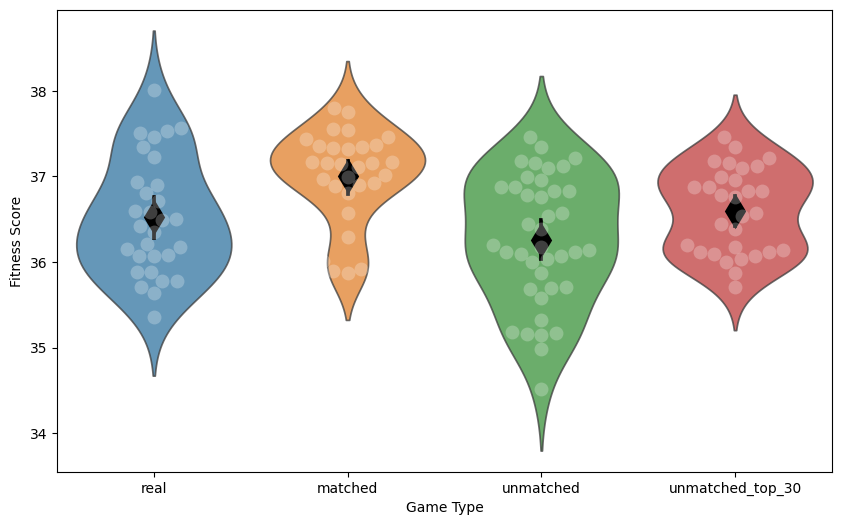

In [60]:
plt.figure(figsize=(10, 6))

sns.violinplot(data=fitness_scores_by_type, palette='tab10', inner=None, alpha=0.75)
sns.swarmplot(data=fitness_scores_by_type, color='white', dodge=False, size=10, alpha=0.25)
sns.pointplot(data=fitness_scores_by_type, errorbar=('ci', 95), linestyle='none', color='black', markers='d', markersize=15)

plt.xlabel('Game Type')
plt.ylabel('Fitness Score')

In [73]:
real_game_keys_to_scores = {REAL_GAME_KEY_LIST[i]: real_game_fitness_scores[idx] for i, idx in enumerate(REAL_GAME_INDICES_TO_INCLUDE)}
matched_game_key_to_scores = {key: model.fitness_values[literal_eval(key)] for key in human_cell_archive_game_texts.keys()}
unmatched_game_key_to_scores = {key: model.fitness_values[literal_eval(key)] for key in novel_archive_cell_game_texts.keys()}
unmatched_game_key_to_scores_without_bottom_10 = {key: model.fitness_values[literal_eval(key)] for key in novel_archive_cell_game_texts.keys()}
unmatched_game_key_to_scores_without_bottom_10 = {k: v for k, v in unmatched_game_key_to_scores_without_bottom_10.items() if v in unmatched_game_fitness_scores_without_bottom_10}


keys_to_fitness_scores = dict(
    real=real_game_keys_to_scores, 
    matched=matched_game_key_to_scores, 
    unmatched=unmatched_game_key_to_scores, 
    unmatched_top_30=unmatched_game_key_to_scores_without_bottom_10
)

full_key_to_fitness_scores = {
    f'{key}-{game_category}': score
    for game_category, key_to_scores in keys_to_fitness_scores.items()
    for key, score in key_to_scores.items()
}

df = pd.DataFrame(full_key_to_fitness_scores.items(), columns=['full_game_id', 'fitness'])
df.to_csv('./human_evals_data/full_game_id_to_fitness.csv', index=False)
df.head()


,full_game_id,fitness
0,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0)-real",36.583473
1,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)-real",36.065643
2,"(1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0)-real",36.416122
3,"(1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)-real",36.933033
4,"(1, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0)-real",36.897301
